In [1]:
import warnings

warnings.filterwarnings(
    "ignore",
)
import os

os.environ["NIXTLA_ID_AS_COL"] = "true"
import numpy as np
import scipy

np.set_printoptions(suppress=True)
np.random.seed(1)
import random

random.seed(1)
from typing import Optional

import pandas as pd
from IPython.display import Image
from scipy.special import inv_boxcox
from scipy.stats import boxcox
from statsforecast.arima import ARIMASummary, ndiffs, nsdiffs
from statsforecast.models import ARIMA, AutoARIMA, AutoETS
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.stattools import kpss
from utilsforecast.losses import mae, rmse, smape

pd.set_option("max_colwidth", 100)
pd.set_option("display.precision", 3)
import seaborn as sns
from utilsforecast.plotting import plot_series as plot_series_utils

sns.set_style("whitegrid")
import matplotlib.pyplot as plt

plt.style.use("ggplot")
plt.rcParams.update(
    {
        "figure.figsize": (8, 5),
        "figure.dpi": 100,
        "savefig.dpi": 300,
        "figure.constrained_layout.use": True,
        "axes.titlesize": 12,
        "axes.labelsize": 10,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
        "legend.fontsize": 9,
        "legend.title_fontsize": 10,
    }
)

# Define a harmonious palette (8 colors)
ggplot_palette = [
    "#E24A33",  # orange-red
    "#348ABD",  # blue
    "#988ED5",  # purple
    "#777777",  # gray
    "#FBC15E",  # yellow
    "#8EBA42",  # green
    "#FFB5B8",  # pink
    "#17BECF",  # cyan
]

# Apply the palette globally
sns.set_palette(ggplot_palette)

from functools import partial

import matplotlib as mpl
from fpppy.utils import plot_series
from IPython.display import Image, Markdown, display
from scipy.optimize import minimize
from sklearn.metrics import mean_squared_error, root_mean_squared_error
from sklearn.model_selection import TimeSeriesSplit, cross_val_score
from statsforecast import StatsForecast
from statsforecast.models import AutoETS
from statsmodels.graphics.tsaplots import plot_acf
from statsmodels.stats.diagnostic import acorr_ljungbox
from statsmodels.tsa.seasonal import STL, seasonal_decompose
from utilsforecast.evaluation import evaluate
from utilsforecast.feature_engineering import fourier, pipeline, trend
from utilsforecast.losses import mae
from utilsforecast.losses import mape
from utilsforecast.losses import mape as _mape
from utilsforecast.losses import mase, mqloss, quantile_loss, rmse


def mape(df, models, id_col="unique_id", target_col="y"):
    df_mape = _mape(df, models, id_col=id_col, target_col=target_col)
    df_mape.loc[:, df_mape.select_dtypes(include="number").columns] *= 100
    return df_mape


from fpppy.models import LinearRegression
from sklearn.linear_model import ElasticNet, LinearRegression
from sklearn.preprocessing import SplineTransformer
from statsforecast import StatsForecast
from statsforecast.models import (
    HistoricAverage,
    Naive,
    RandomWalkWithDrift,
    SeasonalNaive,
    SklearnModel,
    WindowAverage,
)
from statsforecast.utils import ConformalIntervals

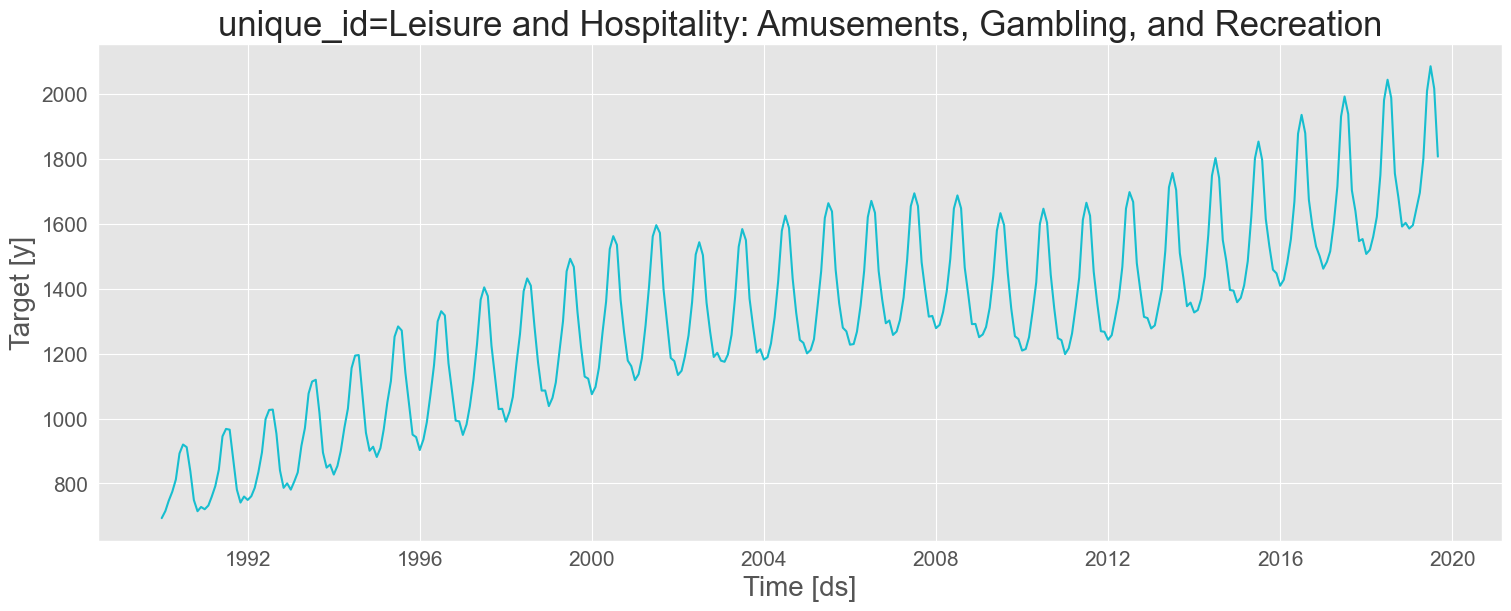

In [2]:
df = pd.read_csv("../DATA/us_employment.csv")
df.ds = pd.to_datetime(df.ds)
df = df[df.unique_id == "Leisure and Hospitality: Amusements, Gambling, and Recreation"]
df = df.dropna().reset_index(drop=True)
plot_series(df)

In [3]:
log_y = np.log(df.y)
kpss(log_y)[1]

C:\Users\basti\AppData\Local\Temp\ipykernel_16444\3520369635.py:2: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss(log_y)[1]


0.01

In [4]:
print(nsdiffs(log_y, period=12))
season_diff_y = log_y.diff(12).dropna()
kpss(season_diff_y)[1]

1


C:\Users\basti\AppData\Local\Temp\ipykernel_16444\4173713868.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is smaller than the p-value returned.

  kpss(season_diff_y)[1]


0.01

In [5]:
print(ndiffs(season_diff_y.values))
diff_y = season_diff_y.diff().dropna()
kpss(diff_y)[1]

1


C:\Users\basti\AppData\Local\Temp\ipykernel_16444\1109345770.py:3: InterpolationWarning: The test statistic is outside of the range of p-values available in the
look-up table. The actual p-value is greater than the p-value returned.

  kpss(diff_y)[1]


0.1

<Axes: ylabel='y'>

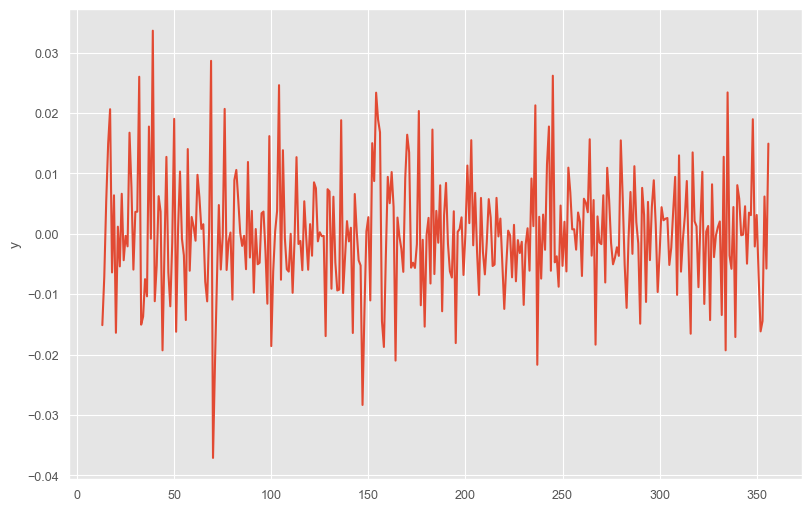

In [6]:
sns.lineplot(diff_y)

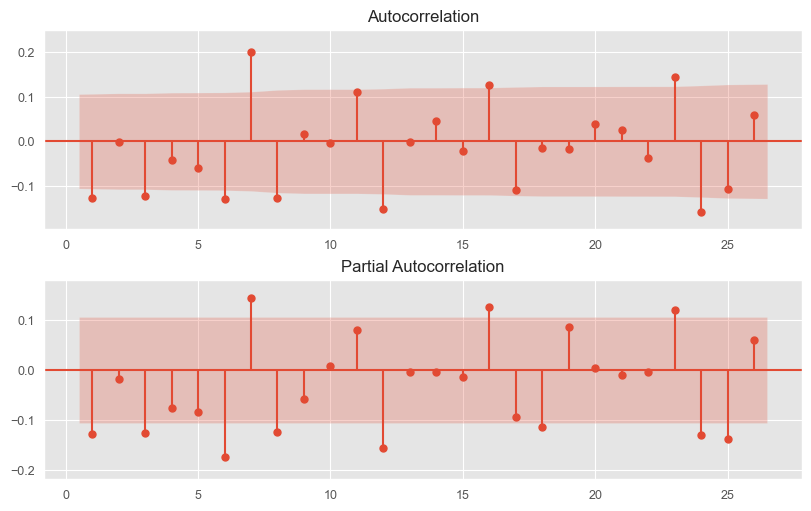

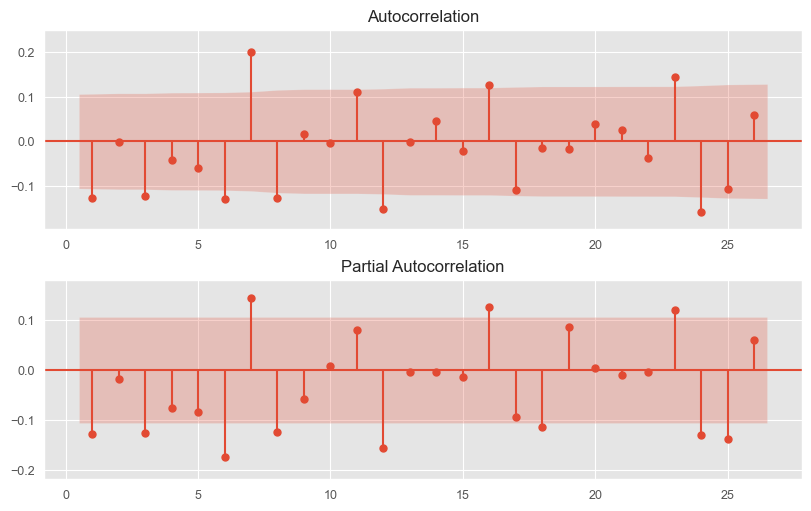

In [7]:
_, axes = plt.subplots(2, 1)

plot_acf(diff_y, ax=axes[0], zero=False, auto_ylims=True)
plot_pacf(diff_y, ax=axes[1], zero=False, auto_ylims=True)

In [8]:
# Potential models

model_1 = ARIMA(order=(3, 1, 3), season_length=12, seasonal_order=(3, 1, 3)).fit(log_y)
model_2 = ARIMA(order=(6, 1, 3), season_length=12, seasonal_order=(4, 1, 3)).fit(log_y)
model_3 = ARIMA(order=(3, 1, 5), season_length=12, seasonal_order=(3, 1, 5)).fit(log_y)
auto = AutoARIMA(stepwise=False, approximation=False, season_length=12).fit(log_y)

In [9]:
model_1.model_["aicc"], model_2.model_["aicc"], model_3.model_["aicc"], auto.model_[
    "aicc"
], ARIMASummary(auto.model_)

(-2238.5950748798614,
 -2225.636927603774,
 -2238.0696275574014,
 -2246.5464570634153,
 ARIMA(0,1,3)(0,1,2)[12]                   )

<Axes: ylabel='y'>

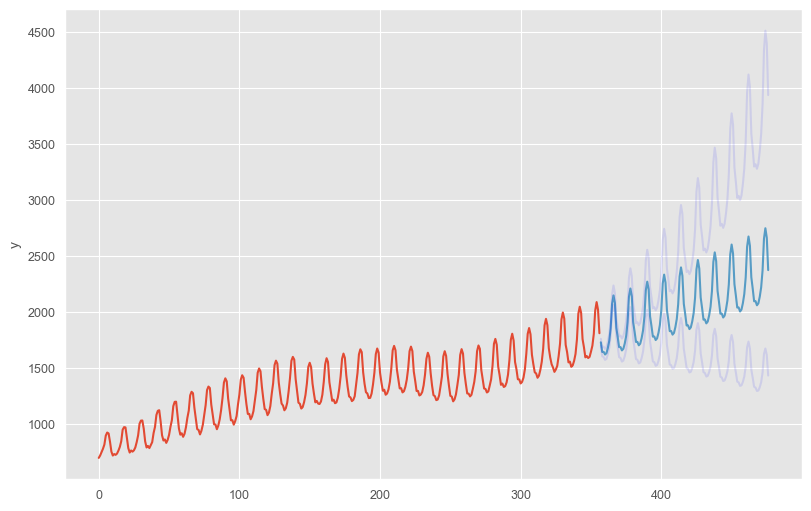

In [10]:
predictions = auto.predict(h=12 * 10, level=[95])

sns.lineplot(df.y)
sns.lineplot(
    x=range(len(log_y), len(log_y) + 12 * 10), y=np.exp(predictions["mean"]), alpha=0.8
)
sns.lineplot(
    x=range(len(log_y), len(log_y) + 12 * 10),
    y=np.exp(predictions["hi-95"]),
    color="blue",
    alpha=0.1,
)
sns.lineplot(
    x=range(len(log_y), len(log_y) + 12 * 10),
    y=np.exp(predictions["lo-95"]),
    color="blue",
    alpha=0.1,
)

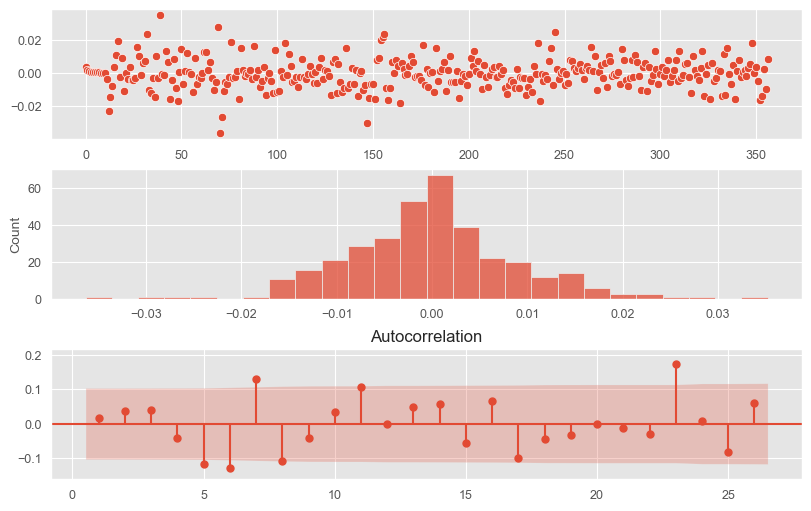

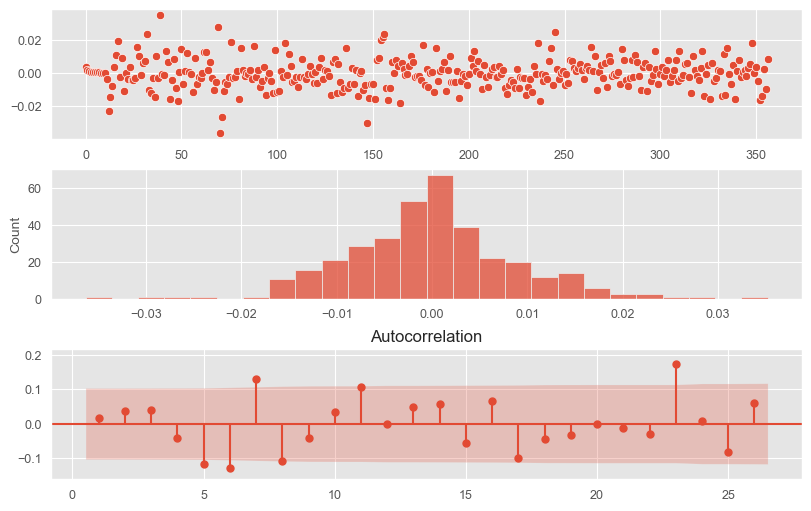

In [11]:
_, axes = plt.subplots(3, 1)

sns.histplot(auto.model_["residuals"], ax=axes[1])
sns.scatterplot(auto.model_["residuals"], ax=axes[0])
plot_acf(auto.model_["residuals"], ax=axes[2], zero=False, auto_ylims=True)

In [12]:
acorr_ljungbox(auto.model_["residuals"], lags=[24], model_df=5)

,lb_stat,lb_pvalue
24,50.46,1.121e-04


In [27]:
from statsmodels.tsa.seasonal import MSTL

osef = df.set_index('ds', drop=True)

mstl = MSTL(osef.y)
res = mstl.fit()

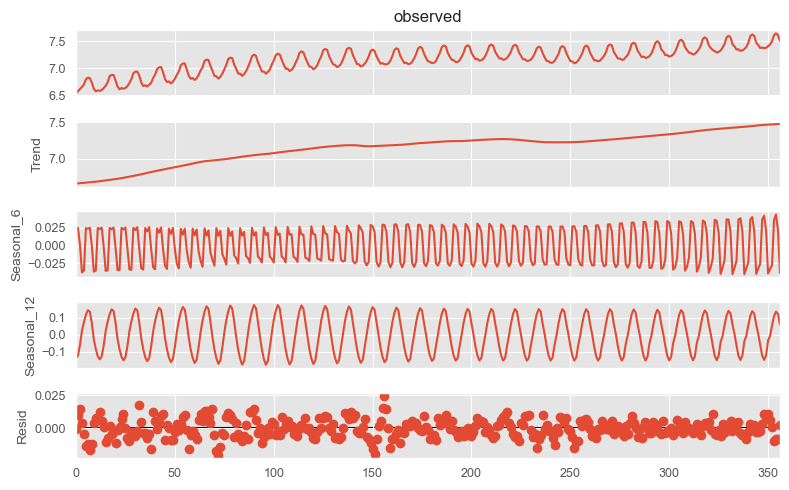

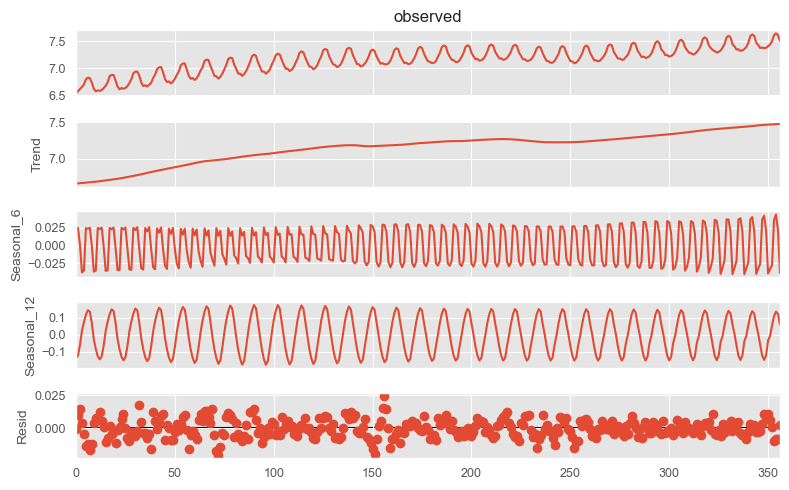

In [23]:
res.plot()